In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from celeriteflow import ops

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
session = tf.Session()

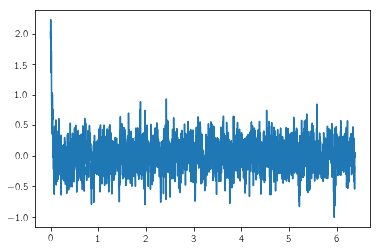

In [15]:
data = np.loadtxt('211351816.dat.ts')

T = tf.float64

t = tf.constant(data[:, 0]*0.0864, dtype=T)
y = tf.constant(data[:, 1:2]*1e3, dtype=T)

log_var = np.log(np.var(data[:,1]*1e3))

plt.plot(*(session.run([t, y])))

In [31]:
log_jitter = tf.Variable(log_var, dtype=T)
log_numax = tf.Variable(np.log(220.0), dtype=T)
log_dnu = tf.Variable(np.log(17.0), dtype=T)
gamma = tf.Variable([0.0, 0.0], dtype=T)
log_H = tf.Variable([log_var, log_var], dtype=T)
log_sigma = tf.Variable(np.log(10.0), dtype=T)
log_Q = tf.Variable(8., dtype=T)

numax = tf.exp(log_numax)
nprime = tf.range(-2.0, 3.0, dtype=T)
ell = tf.range(2, dtype=T)
nu = numax + gamma[None, :] + (tf.exp(log_dnu) * (nprime[:, None] + 0.5*ell[None, :]))
log_amp = log_H[None, :] - 0.5*tf.square(nu - numax)*tf.exp(-2*log_sigma)

w0 = 2*np.pi*nu
Q = 1.0 + tf.exp(log_Q)  # Make sure that Q is always greater than 1
Q2 = tf.square(Q)
S0 = tf.exp(log_amp) / Q2

f = tf.sqrt(4.0 * Q2 - 1.0)
nada = tf.constant([], dtype=T)
a = tf.reshape(S0 * w0 * Q, [-1])
b = tf.reshape(S0 * w0 * Q / f, [-1])
c = tf.reshape(0.5 * w0 / Q, [-1])
d = tf.reshape(0.5 * w0 / Q * f, [-1])

# Granulation terms
log_S0_gran = tf.Variable([log_var - 10.0], dtype=T)
log_w0_gran = tf.Variable(np.log([2*np.pi*100.0]), dtype=T)

arg1 = tf.exp(log_S0_gran + log_w0_gran)
arg2 = 0.5 * tf.exp(log_w0_gran)
a = tf.concat([a, arg1], 0)
b = tf.concat([b, arg1], 0)
c = tf.concat([c, arg2], 0)
d = tf.concat([d, arg2], 0)

A, U, V, P = ops.get_celerite_matrices(nada, nada, a, b, c, d, t, tf.exp(log_jitter) + tf.zeros_like(t))
D, W = ops.celerite_factor(A, U, V, P)
z = ops.celerite_solve(U, P, D, W, y)

chi2 = tf.squeeze(tf.matmul(y, z, transpose_a=True)) + tf.reduce_sum(tf.log(D))

session.run(tf.global_variables_initializer())
print(session.run(chi2))
session.run(tf.gradients(chi2, [log_S0_gran, log_w0_gran]))

-5266.57966717


[array([-83.86276907]), array([-5.57329369])]

In [32]:
# # Hacks to test gradients
# eps = 1e-5
# var = y
# targ = tf.reduce_sum(z)
# v = session.run(var)
# g0 = session.run(tf.gradients(targ, var))[0].flatten()

# s = v.shape
# v = v.flatten()
# g = np.empty_like(v)
# for i in range(len(v)):
#     eye = np.zeros_like(v)
#     eye[i] = eps
#     p = session.run(targ, feed_dict={var: (v+eye).reshape(s)})
#     m = session.run(targ, feed_dict={var: (v-eye).reshape(s)})
#     g[i] = 0.5 * (p - m) / eps
    
# inds = [0, 1, 2, 3, -4, -3, -2, -1]
# g[inds], g0[inds], np.max(np.abs(g - g0))

In [33]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=[log_S0_gran, log_w0_gran])

print(session.run([log_S0_gran, log_w0_gran]))
opt.minimize(session)
print(session.run([log_S0_gran, log_w0_gran]))

[array([-12.62076403]), array([ 6.44304725])]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -5812.392558
  Number of iterations: 13
  Number of functions evaluations: 19
[array([-8.42514692]), array([ 4.79923457])]
